# Predicting coordinates (latitude-longitude) of Terrorist attacking patterns on de_dust2
In this notebook I'll quickly demonstrate how to utilize a Long Short Term Memory Recurrent Neural Network (LSTM) <br>
to predict latitude and longitude coordinates of 4 different games of Terrorists attacking patterns on de_dust2. <br>

<br>
The intention of this is only to highlight how this could be done for any game which records latitude and longitude coordinates. <br>
We'll be training directly on the GPU, if you don't have one then change the epochs parameter. Because the CPU is either slow or can't fit the data.

In [ ]:
import os
os.chdir("D:/gaming_ds/")

import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

from matplotlib.pyplot import imread


from datetime import datetime, timedelta
from scipy.stats import mannwhitneyu


import warnings
warnings.filterwarnings('ignore')

In [2]:
os.getcwd()

'D:\\gaming_ds'

In [6]:
# I am training on an RTX 3060 12GB RAM
torch.cuda.is_available()
device = "cuda" if torch.cuda.is_available() else "cpu"

True

In [8]:
df = pl.scan_csv("cs-go_competitive_mm/mm_master_demos.csv")
map_data = pl.read_csv("cs-go_competitive_mm/map_data.csv")
map_data = map_data.with_columns(map_data[:,0].alias("map")).select(['EndX', 'EndY', 'ResX', 'ResY', 'StartX', 'StartY', 'map'])
maps_to_predict = ["de_dust2"]

map_dedust2 = map_data.filter(pl.col("map").is_in(["de_dust2"]))

In [43]:
df.filter(pl.col("map").is_in(maps_to_predict)).collect()["file"][0], df.filter(pl.col("map").is_in(maps_to_predict)).collect()["file"][189000], df.filter(pl.col("map").is_in(maps_to_predict)).collect()["file"][100000], df.filter(pl.col("map").is_in(maps_to_predict)).collect()["file"][209000]

('003201673717864202280_0171883906.dem',
 '003233738279396311212_0547026752.dem',
 '003230926012120301576_0442460996.dem',
 '003234680655350595702_0221393471.dem')

In [44]:
files_to_train = ['003201673717864202280_0171883906.dem','003233738279396311212_0547026752.dem', '003230926012120301576_0442460996.dem', '003234680655350595702_0221393471.dem']
df_model = df.filter((pl.col("map").is_in(maps_to_predict)) & (pl.col("file").is_in(files_to_train))).collect()[["seconds", "att_pos_x", "att_pos_y", "vic_pos_x", "vic_pos_y"]]

In [45]:
def rescale_coords(input_data: pl.DataFrame) -> pl.DataFrame:
    input_data = input_data.with_columns([
        ((map_dedust2["ResX"] * (pl.col("att_pos_x") - map_dedust2["StartX"])) / (map_dedust2["EndX"] - map_dedust2["StartX"])).alias("scaled_att_pos_x"),
        ((map_dedust2["ResY"] * (pl.col("att_pos_y") - map_dedust2["StartY"])) / (map_dedust2["EndY"] - map_dedust2["StartY"])).alias("scaled_att_pos_y"),

        ((map_dedust2["ResX"] * (pl.col("vic_pos_x") - map_dedust2["StartX"])) / (map_dedust2["EndX"] - map_dedust2["StartX"])).alias("scaled_vic_pos_x"),
        ((map_dedust2["ResY"] * (pl.col("vic_pos_y") - map_dedust2["StartY"])) / (map_dedust2["EndY"] - map_dedust2["StartY"])).alias("scaled_vic_pos_y"),
    ])
    
    return input_data

In [46]:
df_model = rescale_coords(df_model)
df_model.head()

seconds,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y,scaled_att_pos_x,scaled_att_pos_y,scaled_vic_pos_x,scaled_vic_pos_y
f64,f64,f64,f64,f64,f64,f64,f64,f64
133.0582,1473.847,1351.358,662.17,772.748,879.012211,556.219455,698.835049,427.55569
134.9023,-1211.723,1060.813,-1184.006,1153.343,282.865738,491.611838,289.018395,512.187455
135.0586,-1153.584,1163.131,-1198.015,1050.423,295.771512,514.363983,285.908658,489.301445
135.2774,-1173.053,1044.365,-1141.785,1190.089,291.449757,487.954345,298.39067,520.358553
135.4024,-1142.522,1200.967,-1157.69,1050.702,298.22707,522.777461,294.860056,489.363485


In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_model.select(pl.col("scaled_att_pos_x", "scaled_att_pos_y")))

In [48]:
def create_dataset(data, n_lookback=24):
    X, Y = [], []
    for i in range(len(data) - n_lookback):
        X.append(data[i:(i + n_lookback), :])  # skip time for simplicity
        Y.append(data[i + n_lookback, :])
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)


In [49]:
X,y = create_dataset(df_scaled)

In [50]:
X.permute(1,0,2).shape

torch.Size([24, 2269, 2])

In [51]:
X, y = X.to(device), y.to(device)

In [64]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Fully connected layer
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Select last state
        out = self.linear(out[:, -1, :]) 
        return out

# Instantiate model
input_dim = 2
hidden_dim = 50
num_layers = 1
output_dim = 2

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to(device)

In [65]:
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 3000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

Epoch: 0, Loss: 0.3963409960269928
Epoch: 10, Loss: 0.06005917862057686
Epoch: 20, Loss: 0.046291716396808624
Epoch: 30, Loss: 0.04075942933559418
Epoch: 40, Loss: 0.03679654747247696
Epoch: 50, Loss: 0.03435957431793213
Epoch: 60, Loss: 0.03306041657924652
Epoch: 70, Loss: 0.032349057495594025
Epoch: 80, Loss: 0.031850289553403854
Epoch: 90, Loss: 0.03148125484585762
Epoch: 100, Loss: 0.03120368905365467
Epoch: 110, Loss: 0.031030533835291862
Epoch: 120, Loss: 0.030940426513552666
Epoch: 130, Loss: 0.030886802822351456
Epoch: 140, Loss: 0.03084426186978817
Epoch: 150, Loss: 0.03080938570201397
Epoch: 160, Loss: 0.030781006440520287
Epoch: 170, Loss: 0.030756935477256775
Epoch: 180, Loss: 0.03073578141629696
Epoch: 190, Loss: 0.030716555193066597
Epoch: 200, Loss: 0.030698327347636223
Epoch: 210, Loss: 0.03068022057414055
Epoch: 220, Loss: 0.030661242082715034
Epoch: 230, Loss: 0.03064006008207798
Epoch: 240, Loss: 0.030614733695983887
Epoch: 250, Loss: 0.030585378408432007
Epoch: 260,

In [66]:
model.eval()
predicted = model(X)

# Convert predicted to numpy array
predicted = predicted.data.cpu().detach().numpy()

num_features_scaled = 2  # Change this to the actual number of scaled features
unscaled_data = df_model[:len(predicted), 5:7]
np.column_stack((unscaled_data, predicted))

array([[8.79012211e+02, 5.56219455e+02, 4.99169886e-01, 3.28664899e-01],
       [2.82865738e+02, 4.91611838e+02, 5.06688714e-01, 3.25232625e-01],
       [2.95771512e+02, 5.14363983e+02, 4.93243992e-01, 3.43821228e-01],
       ...,
       [9.20629719e+02, 6.66559514e+02, 4.79901373e-01, 6.47303939e-01],
       [8.46826468e+02, 5.38844810e+02, 4.49306190e-01, 4.08014655e-01],
       [1.34329576e+02, 8.44896952e+02, 5.20659208e-01, 6.29718304e-01]])

In [67]:
# Inverse scaling
predicted_actual = scaler.inverse_transform(predicted)

In [68]:
y_test = scaler.inverse_transform(y.cpu().detach().numpy())

Text(0.5, 1.0, 'Real latitude-longitude of Terrorists on de_dust2')

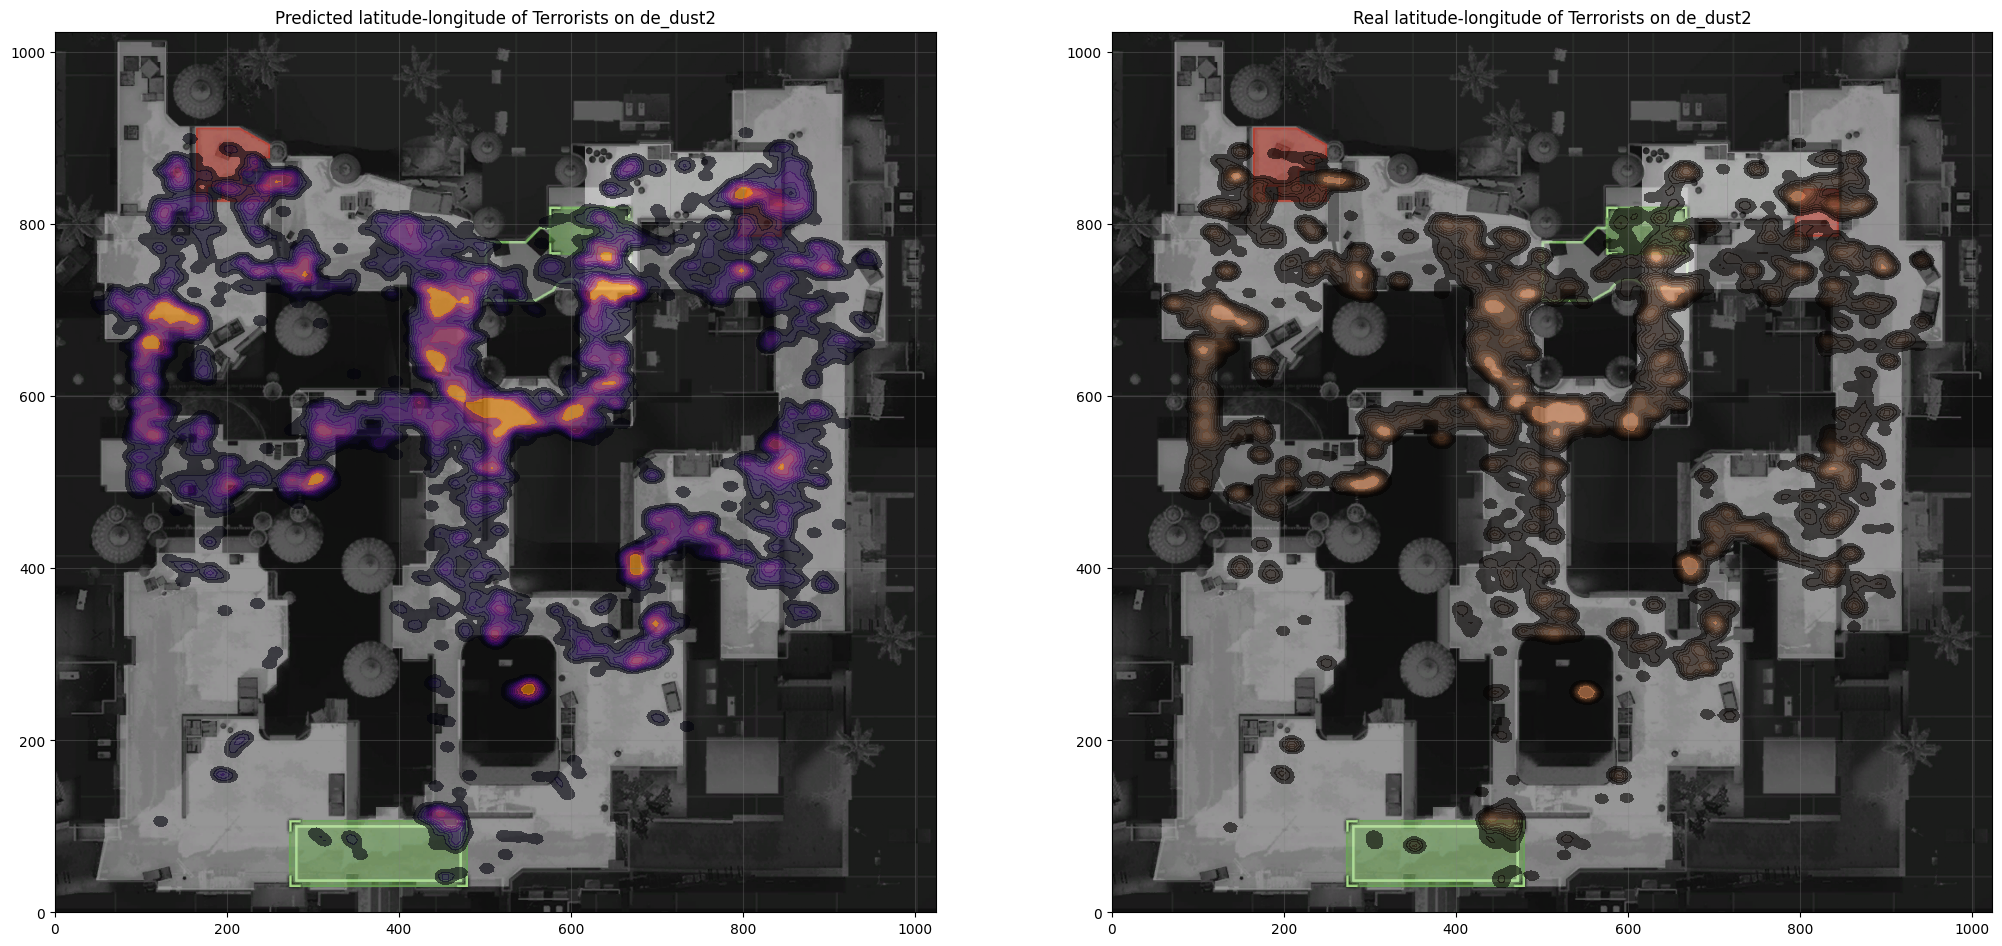

In [69]:
bg = imread('cs-go_competitive_mm/de_dust2.png')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25, 12))
ax1.grid(which='major', color='gray', alpha=.3)
ax1.imshow(bg ,extent=[0.0, 1024, 0.0, 1024], zorder=0)
ax1.set_ylim(0,1024)
ax1.set_xlim(0, 1024)
ax2.grid(which='major', color='gray', alpha=.3)
ax2.imshow(bg ,extent=[0.0, 1024, 0.0, 1024], zorder=0)



ax2.set_ylim(0,1024)
ax2.set_xlim(0, 1024)

sns.kdeplot(x=predicted_actual[:,0], y=predicted_actual[:, 1], ax=ax1, cmap="inferno", fill=True, bw_method=.03, alpha=.6, common_norm=True)
ax1.set_title("Predicted latitude-longitude of Terrorists on de_dust2")

sns.kdeplot(x=y_test[:, 0], y=y_test[:, 1], ax=ax2, cmap="copper", fill=True, bw_method=.03, alpha=.6, common_norm=True)
ax2.set_title("Real latitude-longitude of Terrorists on de_dust2")


<Axes: title={'center': 'Predicted (purple) vs. Real (copper) latitude-longitude of Terrorists on de_dust2'}>

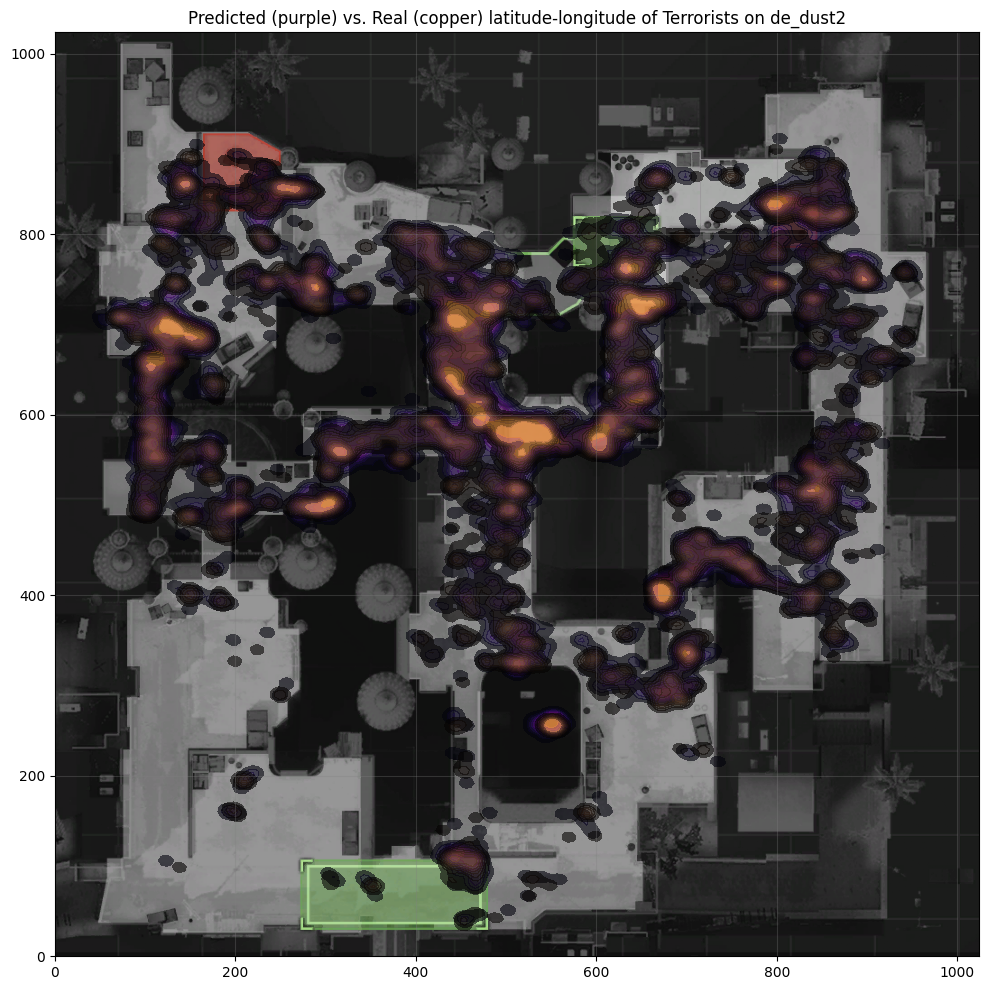

In [72]:
fig, (ax1) = plt.subplots(1,1, figsize=(25, 12))
ax1.grid(which='major', color='gray', alpha=.3)
ax1.imshow(bg ,extent=[0.0, 1024, 0.0, 1024], zorder=0)
ax1.set_ylim(0,1024)
ax1.set_xlim(0, 1024)


sns.kdeplot(x=predicted_actual[:,0], y=predicted_actual[:, 1], ax=ax1, cmap="inferno", fill=True, bw_method=.03, alpha=.6, common_norm=True)
ax1.set_title("Predicted (purple) vs. Real (copper) latitude-longitude of Terrorists on de_dust2")

sns.kdeplot(x=y_test[:, 0], y=y_test[:, 1], ax=ax1, cmap="copper", fill=True, bw_method=.03, alpha=.6, common_norm=True)